In [36]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering

In [2]:
#The data for the Spotify Tracks are taken from the Kaggle Dataset "Spotify Tracks Dataset" which can be found at https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/code

In [3]:
#load the dataset which is 1 block of 114000 entries
dataset_df = pd.read_csv('data/dataset.csv')
print(dataset_df.info())
dataset_df = dataset_df.drop(['Unnamed: 0'], axis=1)
dataset_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
#first the duplicate rows are deleted and the row with null values are deleted
dataset_df = dataset_df.dropna()
dataset_df = dataset_df.drop_duplicates()
dataset_df.shape

(113549, 20)

In [5]:
#the next observation is that some of the columns are non-numerical
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113549 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          113549 non-null  object 
 1   artists           113549 non-null  object 
 2   album_name        113549 non-null  object 
 3   track_name        113549 non-null  object 
 4   popularity        113549 non-null  int64  
 5   duration_ms       113549 non-null  int64  
 6   explicit          113549 non-null  bool   
 7   danceability      113549 non-null  float64
 8   energy            113549 non-null  float64
 9   key               113549 non-null  int64  
 10  loudness          113549 non-null  float64
 11  mode              113549 non-null  int64  
 12  speechiness       113549 non-null  float64
 13  acousticness      113549 non-null  float64
 14  instrumentalness  113549 non-null  float64
 15  liveness          113549 non-null  float64
 16  valence           113549 

In [6]:
#we separate out the string features (except track genre which we take as the target variable) as the boolean feature can easily be converted into an integer feature. Track id is also ignored as it is an identifier and is not related to the genre in any meaningful way.
non_numerical_features = ["artists", "album_name", "track_name"]
dataset_df["explicit"] = [1 if i else 0 for i in dataset_df["explicit"]]

In [7]:
#from the value counts we see that each genre is distributed fairly evenly. The question I want to answer is of there is a way to consolidate the clusters from 114 down to a smaller number to recommend songs easier
dataset_df["track_genre"].value_counts()

track_genre
acoustic       1000
emo            1000
rock-n-roll    1000
reggaeton      1000
disco          1000
               ... 
honky-tonk      981
dance           965
german          963
classical       933
romance         904
Name: count, Length: 114, dtype: int64

In [90]:
#remove non-numerical features to leave the data frame that will be the input to our clustering model
train_num = dataset_df.drop(non_numerical_features+["track_genre","track_id"], axis=1)
train_num.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4


array([[<Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'duration_ms'}>,
        <Axes: title={'center': 'explicit'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>],
       [<Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>],
       [<Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'time_signature'}>, <Axes: >]],
      dtype=object)

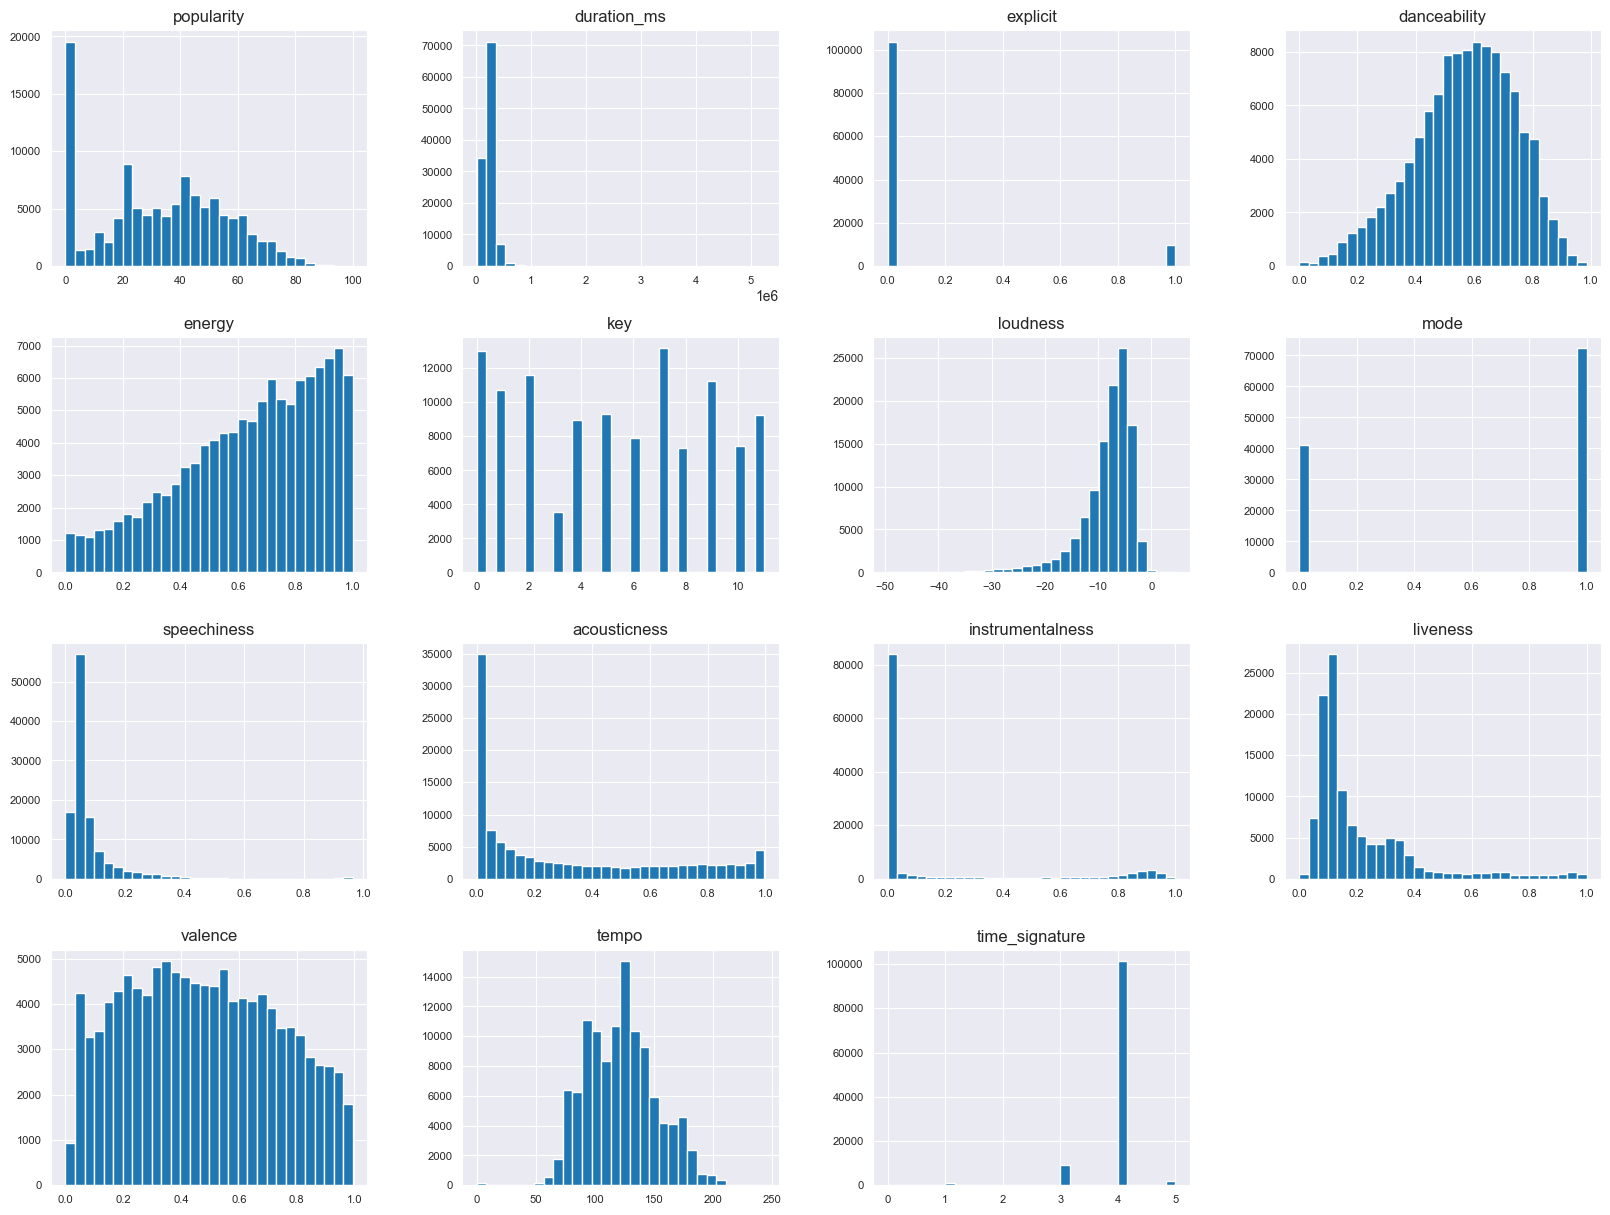

In [91]:
#graph distributions of each numerical feature
train_num.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)

<Axes: >

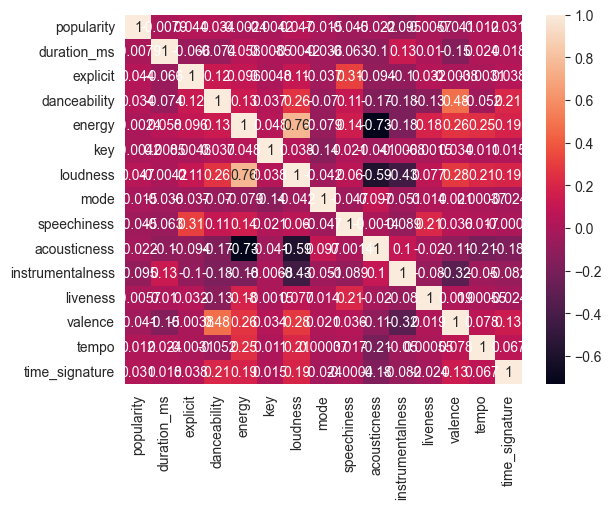

In [95]:
sns.heatmap(train_num.corr(), annot=True)

In [47]:
#The k means and agglomerate clustering algorithms are utilized as well as the matrix factorization to generate the clusters. The initial choice is to use 19 clusters as 19*6=114 
k_cluster_model = KMeans(n_clusters=19)
agglo_cluster_model = AgglomerativeClustering(n_clusters=19, linkage='average', metric='l1')

In [48]:
#Fit and predict on the two clustering algorithms
k_clusters = k_cluster_model.fit_predict(train_num)
#agglo_clusters = agglo_cluster_model.fit_predict(train_num)

In [49]:
agglo_clusters = agglo_cluster_model.fit_predict(train_num)

(array([21147.,  3541., 10381., 17234., 14039., 11950.,   807.,  7426.,
        20027.,  6997.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <BarContainer object of 10 artists>)

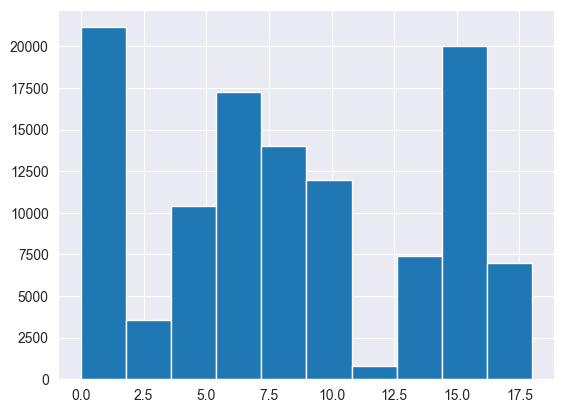

In [50]:
#plotting the results of the k means clustering
plt.hist(k_clusters)

In [59]:
#getting counts of the values of the results of the k means clustering
np.unique(k_clusters, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([16558,  4589,    76,  3465,     9, 10372,  1779, 15455, 14039,
           13, 11937,    37,   770,   230,  7196,  3219, 16808,  6989,
            8], dtype=int64))

In [54]:
#getting counts of the values of the results of the agglomerate clustering
np.unique(agglo_clusters, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18], dtype=int64),
 array([    69,      4,     11, 103774,     19,      6,      2,   8850,
             8,      3,      2,      1,    201,      2,      3,      4,
             1,      2,    587], dtype=int64))

(array([7.30000e+01, 1.03785e+05, 2.50000e+01, 8.85200e+03, 8.00000e+00,
        5.00000e+00, 2.02000e+02, 5.00000e+00, 5.00000e+00, 5.89000e+02]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <BarContainer object of 10 artists>)

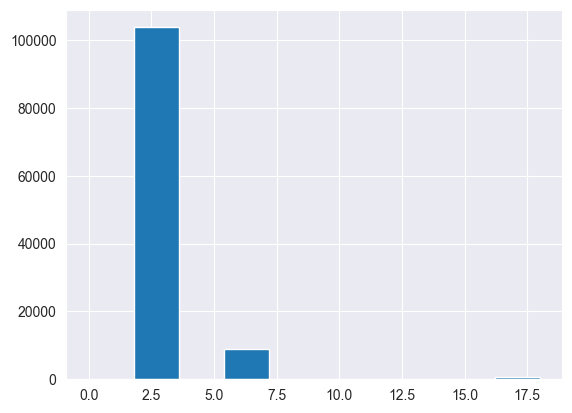

In [52]:
#results of the agglomerate clustering
plt.hist(agglo_clusters)

In [97]:
#based on these results it would be better to use the k means clustering to get to a smaller amount of clusters
recommend_model = KMeans(n_clusters=19)
genre_clusters = recommend_model.fit_predict(train_num.drop(["loudness",'acousticness'], axis=1))

(array([11535., 18079.,   333.,  5361., 17095.,  5065., 10607., 15720.,
        26990.,  2764.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <BarContainer object of 10 artists>)

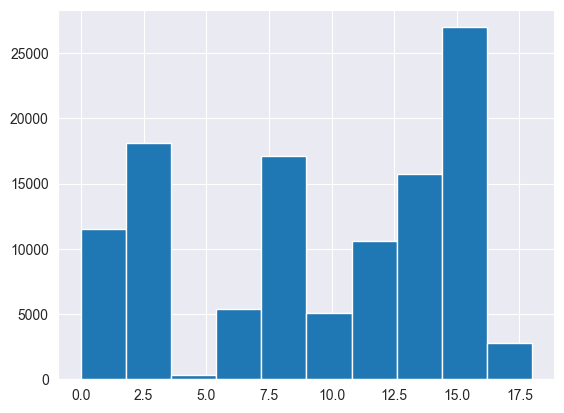

In [98]:
plt.hist(genre_clusters)

In [ ]:
#In conclusion, what is shown is that it is possible to utilize a KMeans Clustering model to reduce the amount of genre clusters. This saves effort in that instead of 114 clusters there are only 19 here to visualize. Additionally, agglomerate clustering was shown to be slow and reduced the data into too consolidated clusters almost making them pointless. 